# Imports

In [1]:
import os
import random
import pickle
import datetime
from multiprocessing import Process, Pool

import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

# Load pickled graphs

In [2]:
graphs_dir = '../data/processed/'
graphs = []
cities_in_dataset = set()
for file in os.listdir(graphs_dir):
    if not file.startswith('CAMDA'):
        print(f'skipping {file}')
        continue
    print(f'reading {file}')
    city_code = os.path.splitext(file)[0].split('_')[3]
    cities_in_dataset.add(city_code)
    with open(os.path.join(graphs_dir, file), 'rb') as f:
        graph = pickle.load(f)
    graphs.append(graph)

reading CAMDA20_MetaSUB_CSD16_BCN_026_1_kneaddata_subsampled_20_percent.labeled_graph_max
reading CAMDA20_MetaSUB_CSD17_HKG_010_1_kneaddata_subsampled_20_percent.labeled_graph_max


/Users/denys_herasymuk/Research/Lviv_Data_Science_School_2024/Code/UCU-GNN_Project/ucu_gnn_venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

## Peek at the objects

In [3]:
print(cities_in_dataset)

{'HKG', 'BCN'}


In [4]:
print(f'{graphs[0] = } | with label {graphs[0].y.item()}')

graphs[0] = Data(x=[512, 25], edge_index=[2, 2141], weight=[2141], y=[1]) | with label 0


In [5]:
# print(f'{graphs[1] = } | with label {graphs[1].y.item()}')

In [6]:
graphs_n = len(graphs)
print(f'total graphs num = {graphs_n}')

total graphs num = 2


# Train GCN

## Data Loaders

In [7]:
random.shuffle(graphs)
split_value = 0.5
# split_value = 0.8
train_dataset = graphs[:int(graphs_n * split_value)]
val_dataset = graphs[int(graphs_n * split_value):]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [8]:
print(f'batches in train dataset = {len(train_loader)}')
print(f'batches in validation dataset = {len(val_loader)}')

batches in train dataset = 1
batches in validation dataset = 1


## Model architecture

In [9]:
# TODO: improve architecture: add more layers, test other readout functions, etc.
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, edge_weight, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_weight)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [10]:
# ---------- these magic numbers were used during graph construction ---------- #
kmer_len = 4
subkmer_len = 2
num_features = 5**subkmer_len # length of each node's feature vector
# ------ num_features is needed to match the shape of the first layer in GCN --- #

In [11]:
print(cities_in_dataset)
num_classes = len(cities_in_dataset)

{'HKG', 'BCN'}


In [12]:
# initialize the model, optimizer, and loss function
model = GCN(num_features=num_features, hidden_channels=32, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [13]:
# train function
def train():
    model.train()
    total_loss = 0
    correct = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.weight, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return total_loss / len(train_loader), correct / len(train_dataset)

# validation function
def validate(loader):
    model.eval()
    correct = 0
    for data in loader:
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.weight, data.batch)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

In [14]:
# training loop
train_loss_for_plot = []
train_acc_for_plot = []
val_acc_for_plot = []

num_epochs = 2000
for epoch in range(num_epochs):
    train_loss, train_acc = train()
    val_acc = validate(val_loader)
    train_loss_for_plot.append(train_loss)
    train_acc_for_plot.append(train_acc)
    val_acc_for_plot.append(val_acc)
    if epoch % 100 == 0:
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1, Train Loss: 0.6238, Train Acc: 1.0000, Val Acc: 0.0000
Epoch 101, Train Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.0000
Epoch 201, Train Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.0000
Epoch 301, Train Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.0000
Epoch 401, Train Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.0000
Epoch 501, Train Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.0000
Epoch 601, Train Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.0000
Epoch 701, Train Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.0000
Epoch 801, Train Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.0000
Epoch 901, Train Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.0000
Epoch 1001, Train Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.0000
Epoch 1101, Train Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.0000
Epoch 1201, Train Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.0000
Epoch 1301, Train Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.0000
Epoch 1401, Train Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.0000
Epoch 1

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl

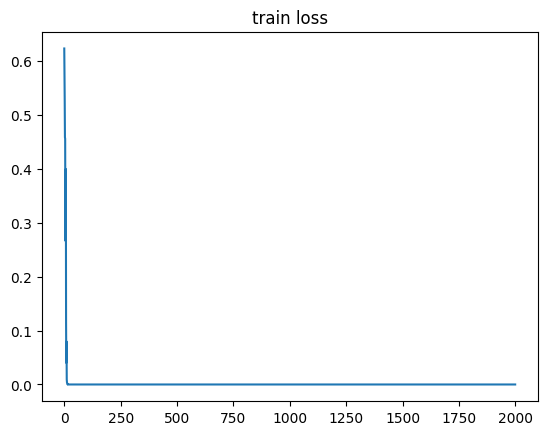

In [16]:
plt.plot(train_loss_for_plot)
plt.title('train loss')
plt.show()

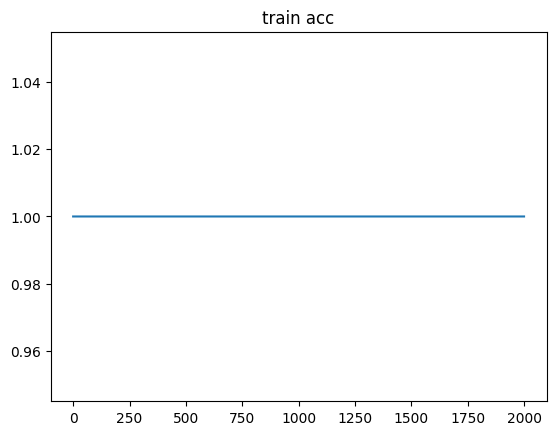

In [17]:
plt.plot(train_acc_for_plot)
plt.title('train acc')
plt.show()

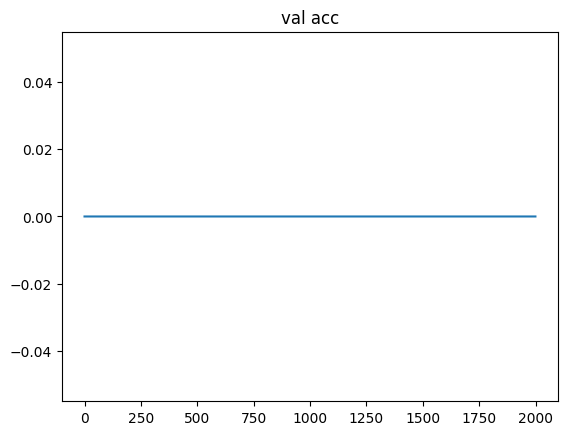

In [18]:
plt.plot(val_acc_for_plot)
plt.title('val acc')
plt.show()

Conclusion: the validation dataset is **too small**. The model seems to be able to exploit the graph structure (supplied with edge weights and node attributes) to produce meaningful graph representations (embeddings) which can be seen from the train accuracy plot. However, the existing setup naturally **fails** to generalize on unseen samples.

Next steps: 
* collect a larger dataset
* improve network architecture
* add more features to graph edges and nodes (+ literature review on best practices)